In [1]:
import os, sys, gc, time, pickle, importlib
from numba import jit, i4, f4
from numba.experimental import jitclass
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

from sklearn.preprocessing import StandardScaler
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import pivnet
importlib.reload(pivnet)

<module 'pivnet' from '/Users/yusuke/workspace/pivnet/pivnet.py'>

## Parameter Setting
---

In [2]:
k_max = 50
dim = 2
n = 200_000
n_train = 100_000
n_test = 10_000

grid = 1024
margin = 1.
n_units = [k_max+dim+1, 64, 64, 32, k_max]
batch_size = 500
max_epoch = 50
patience = 10
min_delta = 0
learning_rate = 1e-1

## Prepare dataset
---

### Prepare queries

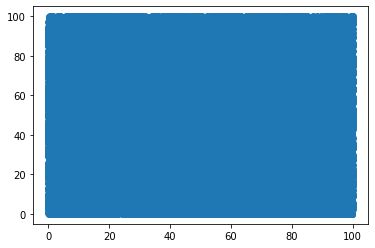

In [3]:
bottom_left = [0, 0]
upper_right = [100, 100]

rng = np.random.default_rng(42)
database = rng.uniform(
    low=bottom_left,
    high=upper_right,
    size=(n, dim)
).astype('float32')

plt.scatter(database[:, 0], database[:, 1])

In [4]:
train_queries = rng.uniform(
    low=bottom_left,
    high=upper_right,
    size=(n_train, dim)
).astype('float32')

test_queries = rng.uniform(
    low=bottom_left,
    high=upper_right,
    size=(n_test, dim)
).astype('float32')

In [5]:
query_scaler = StandardScaler()
query_scaler.fit(train_queries)

StandardScaler()

### Prepare exact kNN distances

In [6]:
tree = KDTree(database)
train_knnd = tree.query(train_queries, k=k_max)[0].astype('float32')
test_knnd = tree.query(test_queries, k=k_max)[0].astype('float32')

In [7]:
knnd_scaler = StandardScaler()
train_knnd_scaled = knnd_scaler.fit_transform(train_knnd)
test_knnd_scaled = knnd_scaler.transform(test_knnd)

In [8]:
x_train = torch.from_numpy(train_queries).float()
y_train = torch.from_numpy(train_knnd_scaled).float()
train_dataloader = DataLoader(
    pivnet.SimpleDataset(x_train, y_train),
    batch_size=batch_size,
    shuffle=True
)

x_test = torch.from_numpy(test_queries).float()
y_test = torch.from_numpy(test_knnd_scaled).float()

### Prepare pivots

In [9]:
pivots = pivnet.generate_pivots(
    database, grid, k_max, margin=margin, n_threads=8
)

## Training and evaluation
---

In [10]:
net = pivnet.PivNet(n_units, pivots, query_scaler, knnd_scaler)
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
criterion = nn.L1Loss(reduction='mean')

In [11]:
for epoch in range(max_epoch):
    net.train()
    for x_batch, y_batch in train_dataloader:
        optimizer.zero_grad()

        output = net(x_batch)
        loss = criterion(output, y_batch)

        loss.backward()
        optimizer.step()

In [12]:
net.eval()
with torch.no_grad():
    output = net.estimate(x_test)
mae = abs(output - test_knnd).mean()
mae

tensor(0.0126, dtype=torch.float64)